In [1]:
# ╔═╡ 70122f72-ce57-11ed-34a3-edae52aeeea1
begin
	using Random
	using LinearAlgebra
	using Statistics: mean
end

# ╔═╡ 15481c8b-7a2a-46ae-bc99-86887b504106
begin
	using Plots
	using Flux
	using STFT
end

# ╔═╡ 9c2ef567-0e18-4b5a-ab99-b51c32cde693
using Flux: train!, mse

In [2]:
# ╔═╡ 03130321-be9c-4aaf-9b22-505d072fc565
begin
	# Generate notes for fake data set
	sample_rate = 44000. / 16. # 16th reduction from typical sample rate
	t = range(0, 1.5, step=1/sample_rate)
	f = 100; #Hz
end

# ╔═╡ 9a29e245-3124-4beb-abd6-085810af4c4f
begin
	# amplitude normalization slightly under 1 to avoid speaker clipping issues
	ceiling = 0.98
	normalized(y) =  y ./ maximum(abs.(y)) .* ceiling
end

# ╔═╡ 6fc6eb2a-44f8-4051-b95f-cb526dcc7404
function delay_note(y, t, delay)
    index = findfirst(t .>= delay)
    z = copy(y)
    z[index:end] = y[1:end-index+1]
    z[1:index-1] .= 0
    return z
end

# ╔═╡ 06d52688-756b-43ee-b73f-81a5d5426d56
function make_note(t, f₀; N=10, delay=0, ϕ=0)
    y = sum(exp.(-n*t).*sin.(2π*f₀*t*n .+ ϕ)/n for n ∈ 1:N) #N is number of harmonics
    if delay != 0
        y = delay_note(y, t, delay)
    end
    return normalized(y)
end

# ╔═╡ 8e0661d1-990e-4e08-a09d-899112552abc
function arp_chord(t, notes, delays)
    y = sum(make_note(t,note,delay=delay) for (note,delay) ∈ zip(notes,delays))
    return normalized(y)
end

# ╔═╡ 3f357a03-d651-4343-a364-4524973a7f92
function hann(N::Int)
    N = N - N % 2 #makes sure N even
    n = 0:N
    return @. sin(π*n/N)^2
end

hann (generic function with 1 method)

In [3]:
# ╔═╡ b757cfa2-cf52-4555-9f5d-880f2f15d3b5
begin
	# Set seed
	Random.seed!(314)

	# STFT Parameters
	w = 250         # window width
	hop = w÷2 - 1   # number of samples to hop over
	window = hann(w)
	N = sample_rate÷2
	T = maximum(t)

	# Notes to be played, major triad has ratio 2:3:5
	notes = [100, 150, 250] #Hz
	
	# Matrix Sizes
	m, n = size(stft(t, window, hop))
	r = length(notes)
	freqs = range(0, N, m)
	times = range(0, T, n)

	# Dataset Sizes
	train_set_size = 40
	test_set_size  = 5

	# Number of Layers
	n_layers = 20
end

20

In [4]:
# ╔═╡ 1c64cd5c-7635-4b8d-ba1a-7b414c4391ad
function envelope(t, delay)
    ϵ = 0 #1e-4 #prevent divide by zero errors
    a = @. exp(-(t - delay)) * (t .>= delay)
    return @. a + (ϵ * (t < delay))
end

# ╔═╡ feda7445-89ed-4091-871a-f0467455a037
function make_VH()
    delays = [rand()*(T-0.5) for _ ∈ notes]
    y = arp_chord(t,notes,delays)
    V = abs.(stft(y, window, hop))
    H = vcat([envelope(times, delay)' for delay ∈ delays]...)
    return (V,H)
end

# ╔═╡ 5c03014b-8c96-47ec-aa6d-4ebd7081a212
begin
	# Make the datasets
	train = [make_VH() for _ ∈ 1:train_set_size]
	test  = [make_VH() for _ ∈ 1:test_set_size]
	train_H = [H for (_, H) ∈ train]
	train_V = [V for (V, _) ∈ train]
	test_H = [H for (_, H) ∈ test]
	test_V = [V for (V, _) ∈ test]
	data = zip(train_V, train_H)
	testing_data = zip(test_V, test_H)
end

zip([[0.10049981242988436 1.865563861301609 … 0.00041710677998541 0.003225853065626172; 0.1003104850261238 1.887014244767945 … 0.0007542099548374903 0.0033875706059650376; … ; 0.01225416196451249 0.20508666806627165 … 0.0004622951744966612 0.0003001736896851109; 0.01224287293046604 0.20491932221714254 … 3.560986217931862e-5 2.880464339419096e-5], [0.0 0.0 … 0.004355045498359411 0.000487242336871363; 0.0 0.0 … 0.004612409940697574 0.0007159721357534446; … ; 0.0 0.0 … 0.0032829502216956546 0.002081065111019901; 0.0 0.0 … 0.00024125935093882183 0.00027598013582186905], [0.0 0.0 … 0.0013265475529745663 0.0031183202573372704; 0.0 0.0 … 0.001527677239779377 0.00333787090030503; … ; 0.0 0.0 … 0.003049513057927405 0.002026851701050666; 0.0 0.0 … 0.0003348326392458593 0.0001897363546535834], [0.03976318438839296 0.864836456669027 … 0.0004618591842459052 0.003032589874809033; 0.03986614013735649 0.8650850712104109 … 0.0006473969170999511 0.0032373275663444244; … ; 0.012630619656604999 0.27129860

In [47]:
# ╔═╡ 01c584d6-b102-431d-bc05-f43d8f60d36c
# Define the ALS NN Layer
ReLU(x) = max.(x, 0)

struct ALSLayer
    W
end

W_init = abs.(randn((m,r))) #use the same random initialization
function ALSLayer(m,r)
    W = W_init
    ALSLayer(W)
end

function (a::ALSLayer)((E, H))
    W = a.W
    #H_old = H
    H_new = zeros(r,n) # H_new = ReLU( (E + W*H')'*H )'
    #E = E - W*(H_new - H_old)
    i=1
    for (w,h) ∈ zip(eachcol(W), eachrow(H))
        h_old = h
        h_new = ReLU( (E + w*h')'*w )
        E = E - w*(h_new - h_old)'
        H_new[i,:] = h_new
        i+=1
    end
    return (E, H_new)
end

Flux.@functor ALSLayer (W,) #declare the weights W as trainable parameters

In [48]:
# Define the model
struct MyModel
	chain::Chain
end
H_init = abs.(randn((r,n))) 
function (m::MyModel)(V::Matrix{Float64})
	#W = Flux.params(m)[1]
	#H_init = W \ V # Least Squares Initialization
	E_init = V - W_init * H_init
	(E_out, H_out) = m.chain((E_init, H_init))
	return H_out
end

function (m::MyModel)(V::Vector{Matrix{Float64}})
	return m.(V) #apply m to all elements in V
end
	
Flux.@functor MyModel

In [49]:
# ╔═╡ 6e567463-2b84-4472-9fa6-050e2e97d4ce
begin
	# Create the NN
	my_layer = ALSLayer(m,r)
	chain = Chain([my_layer for _ ∈ 1:n_layers]) # shared parameters
	#chain = Chain([MyLayer(m,r) for _ ∈ 1:n_layers]) # different parameters
	model = MyModel(chain)
end

# ╔═╡ 32f07151-5b8c-4412-a3f3-b85515d93fa9
model(train_V[1])

# ╔═╡ fd523a2f-cde6-4b2f-977f-bc32ea9c6dfb
Flux.params(model)

Params([[0.4089081508783817 1.0502428911576185 0.7922475557393942; 0.01922396656474979 0.501358655918065 0.9740082676013043; … ; 0.43934301838488227 1.0945381976665345 0.4290060985405931; 1.1253762058192243 1.5623007392977162 1.1836699057045545]])

In [50]:
train!(loss, model, data, opt)

ErrorException: Mutating arrays is not supported -- called setindex!(Matrix{Float64}, ...)
This error occurs when you ask Zygote to differentiate operations that change
the elements of arrays in place (e.g. setting values with x .= ...)

Possible fixes:
- avoid mutating operations (preferred)
- or read the documentation and solutions for this error
  https://fluxml.ai/Zygote.jl/latest/limitations


In [8]:
# ╔═╡ f719af93-5fd5-4690-b9d4-9ba5852b5f6d
loss(model, V_input, H_truth) = mse(model(V_input), H_truth)

# ╔═╡ fa4f0aa7-07d4-4960-b4e8-86a8e1d9e51b
opt = Descent()

# ╔═╡ af0b1669-f09c-430a-823c-2501fa6104e1
#train!(loss, model, data, opt)

# ╔═╡ 572e17af-3a5a-42e1-a790-9c545e202ae4
function my_train(maxit=50)
    train_test_ratio = 1#train_set_size/test_set_size
    training_loss = zeros(1,maxit)
    testing_loss  = zeros(1,maxit)
    for i ∈ 1:maxit
        train!(loss, model, data, opt)
        training_loss[i] = mean(loss(model, V, H) for (V,H) ∈ data)
        testing_loss[i]  = mean(loss(model, V, H) for (V,H) ∈ testing_data)
    end
    return training_loss, testing_loss*train_test_ratio
end

my_train (generic function with 2 methods)

In [20]:
maxit = 50
training_loss, testing_loss = my_train(maxit)

([0.2713401733290056 0.2713401733290056 … 0.2713401733290056 0.2713401733290056], [0.27565313240690587 0.27565313240690587 … 0.27565313240690587 0.27565313240690587])

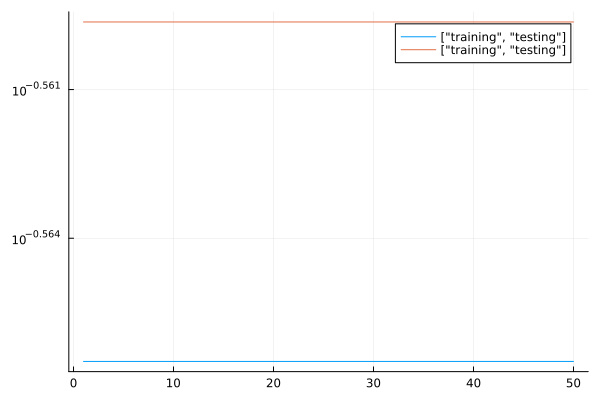

In [21]:
# ╔═╡ 08987c7d-2029-4be0-8e49-9e92b4912477
plot(1:maxit,[training_loss',testing_loss'],label=["training", "testing"], yscale=:log10)

In [11]:
# ╔═╡ 7ab02d01-7201-42eb-825f-0e9516cddecd
learned_W = abs.(Flux.params(model)[1])

# ╔═╡ cdd94d93-deaa-4ff5-a78f-ee76b61b2f72
function plot_Ws(W)
	p1 = plot(freqs,W[:,1], color=:blue, label = "w1")
	p2 = plot(freqs,W[:,2], color=:red, label = "w2")
	p3 = plot(freqs,W[:,3], color=:green, label = "w3", xlabel = "frequency (Hz)")
	plot(p1,p2,p3, layout=(r,1))
	plot!(xticks=0:100:1400)
end

# ╔═╡ 89305234-16cb-4704-9a11-dcf5db583ae8
function plot_Hs(H)
	p1 = plot(times,H[1,:], color=:blue, label = "h1")
	p2 = plot(times,H[2,:], color=:red, label = "h2")
	p3 = plot(times,H[3,:], color=:green, label = "h3", xlabel = "time (s)")
	plot(p1,p2,p3, layout=(r,1))
end

plot_Hs (generic function with 1 method)

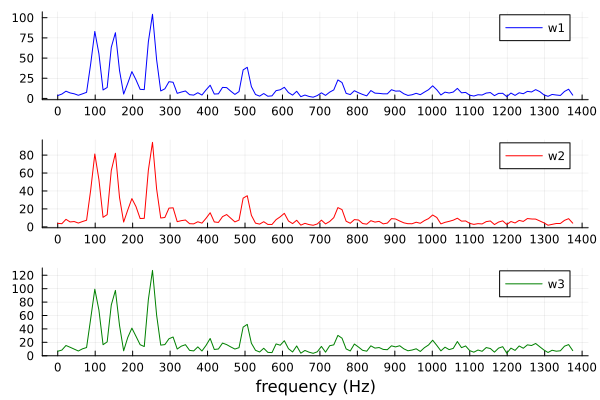

In [12]:
# ╔═╡ 182c37b5-80c9-4a82-95e2-957859fa93b9
plot_Ws(learned_W)

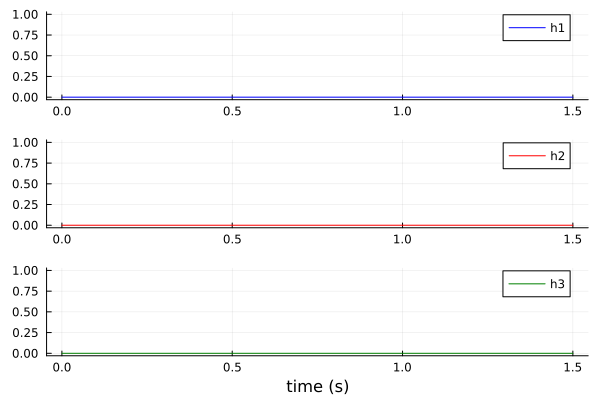

In [13]:
# ╔═╡ c1e6d11f-0b80-464e-96ce-cba6e3ef37a0
plot_Hs(model(train_V[1]))